# Trading strat

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
folder_path = 'data\\5y\\'
csv_path = folder_path + 'BTCUSDT-1d-from-2017-08-to-2021-08.csv'

df = pd.read_csv(csv_path)

In [3]:
#put a certain amount of USDT forward to buy BTC
def buy(acc_usdt, acc_btc, buy_price, buy_amount):
    if(acc_usdt >= buy_amount):
        acc_usdt -= buy_amount
        acc_btc += buy_amount/buy_price
    return acc_usdt, acc_btc

#put a certain amount of BTC forward to buy USDT (aka sell)
def sell(acc_usdt, acc_btc, sell_price, sell_amount):
    if(acc_btc >= sell_amount):
        acc_usdt += sell_amount*sell_price
        acc_btc -= sell_amount
    return acc_usdt, acc_btc


#put a certain amount of USDT forward to buy BTC
#Now with TAXES YEAH
def buy_t(acc_usdt, acc_btc, buy_price, buy_amount):
    if(acc_usdt >= buy_amount):
        acc_usdt -= buy_amount
        acc_btc += (buy_amount - buy_amount*0.001)/buy_price
    return acc_usdt, acc_btc

#put a certain amount of BTC forward to buy USDT (aka sell)
#Now with TAXES YEAH
def sell_t(acc_usdt, acc_btc, sell_price, sell_amount):
    if(acc_btc >= sell_amount):
        acc_usdt += (sell_amount - sell_amount*0.001)*sell_price
        acc_btc -= sell_amount
    return acc_usdt, acc_btc

In [4]:
def low(df, curr, p):
    l = min(df['Low'][curr - p + 1 : curr + 1])
    return l

#low(df, df.index[-1], 9)

def high(df, curr, p):
    h = max(df['High'][curr - p + 1 : curr + 1])
    return h

#high(df, df.index[-1], 9)

## KDJ 2 : the adventures of captain WTF

In [5]:
def rsv(df, p):
    return [(df['Close'][curr] - low(df, curr, p))/(high(df, curr, p) - low(df, curr, p)) for curr in range(p, len(df))]


def k(df_l, RSV, p):
    K = [0.5]
    for i in range(1, df_l - p):
        K.append((2/3)*K[i-1] + (1/3)*RSV[i])
    return K

#k(len(df), RSV, 9)

def d(df_l, K, q):
    D = [0.5]
    for i in range(1, df_l - q):
        D.append((2/3)*D[i-1] + (1/3)*K[i])
    return D

#d(len(df), K, 9)

def j(df_l, K, D, p):
    return [3*K[i] - 2*D[i] for i in range(df_l - p)]

In [6]:
RSV = rsv(df, 9)
K = k(len(df), RSV, 9)
D = d(len(df), K, 9)
J = j(len(df), K, D, 9)

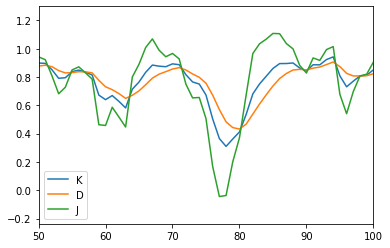

In [7]:
plt.xlim(50,100)
plt.plot(K)
plt.plot(D)
plt.plot(J)
plt.legend(["K","D","J"])

## Backtesting KDJ 2

In [8]:
def kdj_fee(df, p):
    acc_usdt = 1
    acc_btc = 0

    prev_price = df['Open'][df.index[0]] #USDT
    acc_hist = [1]
    
    RSV = rsv(df, p)
    K = k(len(df), RSV, p)
    D = d(len(df), K, p)
    J = j(len(df), K, D, p)

    for i in range(len(df) - p):
        curr_price = df['Open'][df.index[i + p]] #USDT
        k_curr = K[i]
        d_curr = D[i]
        if(k_curr < d_curr):
            acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
        if(k_curr > d_curr):
            acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, prev_price, acc_usdt)

        acc_usdt_tmp, acc_btc_tmp = sell(acc_usdt, acc_btc, prev_price, acc_btc)
        acc_hist.append(acc_usdt_tmp)
        prev_price = curr_price

    acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, prev_price, acc_btc)
    return acc_usdt

In [9]:
paths = [folder_path + 'BTCUSDT-30m-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-1h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-2h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-2h-1h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-4h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-6h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-1d-from-2017-08-to-2021-08.csv']

cmp = []

for i, e in enumerate(paths):
    print(e)
    csv_path = paths[i]
    df = pd.read_csv(csv_path)

    cmp.append(kdj_fee(df, 9))
    

data\5y\BTCUSDT-30m-from-2017-08-to-2021-08.csv
data\5y\BTCUSDT-1h-from-2017-08-to-2021-08.csv
data\5y\BTCUSDT-2h-from-2017-08-to-2021-08.csv
data\5y\BTCUSDT-2h-1h-from-2017-08-to-2021-08.csv
data\5y\BTCUSDT-4h-from-2017-08-to-2021-08.csv
data\5y\BTCUSDT-6h-from-2017-08-to-2021-08.csv
data\5y\BTCUSDT-1d-from-2017-08-to-2021-08.csv


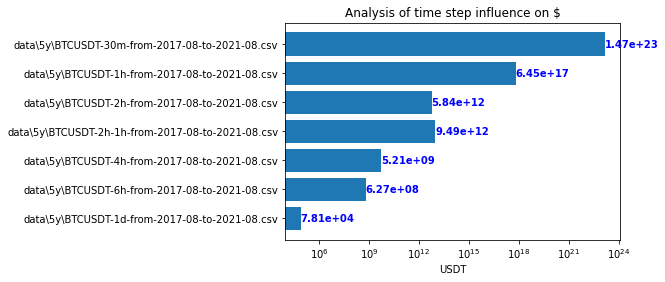

In [10]:
fig, ax = plt.subplots()

y_pos = np.arange(len(paths))
ax.barh(y_pos, cmp, align='center', log=True)
plt.yticks(y_pos, labels=paths)
ax.invert_yaxis()
for i, v in enumerate(cmp):
    ax.text(v, i + 0.1, str("{:.2e}".format(v)), color='blue', fontweight='bold')
ax.set_xlabel('USDT')
ax.set_title('Analysis of time step influence on $')

plt.show()

In [11]:
paths = [folder_path + 'BTCUSDT-30m-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-1h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-2h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-2h-1h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-4h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-6h-from-2017-08-to-2021-08.csv',
         folder_path + 'BTCUSDT-1d-from-2017-08-to-2021-08.csv']

cmp = np.zeros((7, 6))

for i, e in enumerate(paths):
    print(e)
    for w in range(6, 12):
        print(w)
        csv_path = paths[i]
        df = pd.read_csv(csv_path)

        cmp[i][w-6] = kdj_fee(df, w)

data\5y\BTCUSDT-30m-from-2017-08-to-2021-08.csv
6
7
8
9
10
11
data\5y\BTCUSDT-1h-from-2017-08-to-2021-08.csv
6
7
8
9
10
11
data\5y\BTCUSDT-2h-from-2017-08-to-2021-08.csv
6
7
8
9
10
11
data\5y\BTCUSDT-2h-1h-from-2017-08-to-2021-08.csv
6
7
8
9
10
11
data\5y\BTCUSDT-4h-from-2017-08-to-2021-08.csv
6
7
8
9
10
11
data\5y\BTCUSDT-6h-from-2017-08-to-2021-08.csv
6
7
8
9
10
11
data\5y\BTCUSDT-1d-from-2017-08-to-2021-08.csv
6
7
8
9
10
11


In [12]:
#cmp = cmp_save
cmp_save = cmp

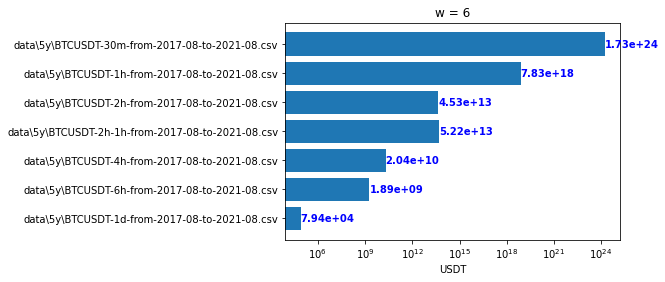

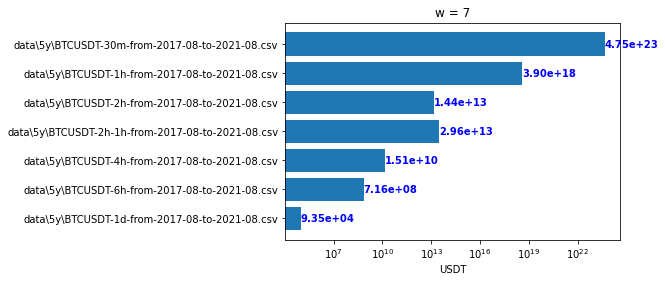

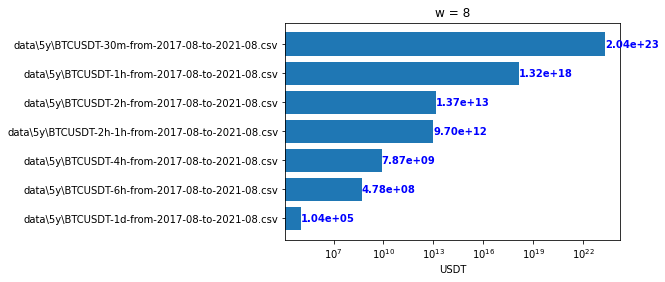

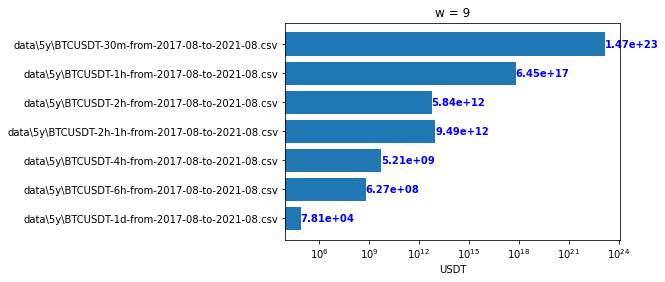

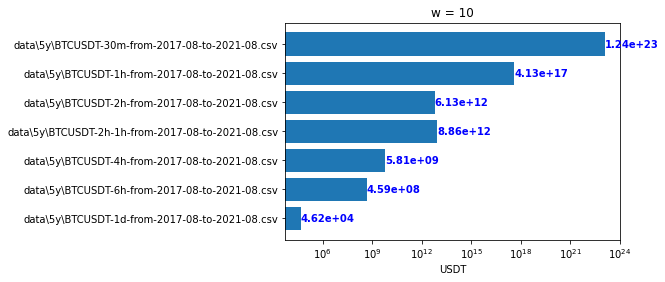

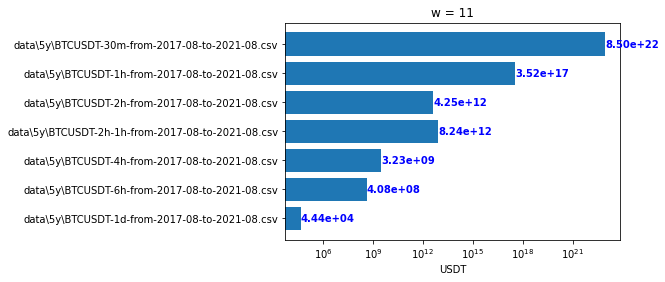

In [13]:
for w in range(6, 12):
    fig, ax = plt.subplots()

    y_pos = np.arange(len(paths))
    line = cmp[:,w-6]
    ax.barh(y_pos, line, align='center', log=True)
    plt.yticks(y_pos, labels=paths)
    for i, v in enumerate(line):
        ax.text(v, i + 0.1, str("{:.2e}".format(v)), color='blue', fontweight='bold')
    ax.invert_yaxis()
    ax.set_xlabel('USDT')
    ax.set_title('w = ' + str(w))

    plt.show()

In [14]:
paths = [folder_path + 'BTCUSDT-30m-from-2017-08-to-2021-08.csv']

cmp = []

for w in range(3, 9):
    print(w)
    csv_path = paths[0]
    df = pd.read_csv(csv_path)

    cmp.append(kdj_fee(df, w))

3


<ipython-input-5-eb34ac64f9c7>:2: RuntimeWarning: invalid value encountered in double_scalars
  return [(df['Close'][curr] - low(df, curr, p))/(high(df, curr, p) - low(df, curr, p)) for curr in range(p, len(df))]


4
5
6
7
8


In [15]:
cmp

[6.669811323416537e+20,
 1.8465592085357176e+25,
 5.763003778892862e+24,
 1.7339397820026964e+24,
 4.7491068196454084e+23,
 2.039865806008333e+23]

In [16]:
cmp_save2 = cmp

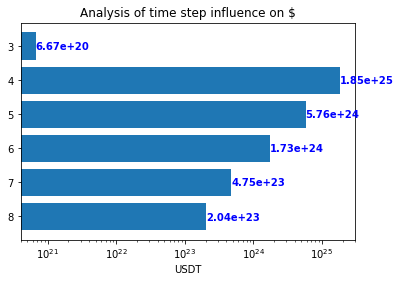

In [17]:
fig, ax = plt.subplots()

y_pos = np.arange(len(cmp))
ax.barh(y_pos, cmp, align='center', log=True)
plt.yticks(y_pos, labels=[3, 4, 5, 6, 7, 8])
ax.invert_yaxis()
for i, v in enumerate(cmp):
    ax.text(v, i + 0.1, str("{:.2e}".format(v)), color='blue', fontweight='bold')
ax.set_xlabel('USDT')
ax.set_title('Analysis of time step influence on $')

plt.show()

# Conclusion

KDJ 2 is much faster than KDJ 1, and gives much better results with less data, so no reasons to continue with KDJ 1

Best parameters found are 30min candles, and a window of 4